#구글 드라이브 mount


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Human_understand/KEMDy19

/content/gdrive/MyDrive/Human_understand/KEMDy19


# 필요한 라이브러리 import


In [3]:
import os
import glob
import pickle
import librosa
import pandas as pd
import numpy as np
import sklearn

import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from IPython.display import Image
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.python.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD

#데이터셋 불러오기

X_data 불러오기

In [4]:
X_data_wav = '/content/gdrive/MyDrive/Human_understand/KEMDy19/needed_mfcc.npy'

Y_data 불러오기

In [5]:
Y_data_wav = '/content/gdrive/MyDrive/Human_understand/KEMDy19/needed_mfcc_y.pkl'

X_data,Y_data를 로드

In [6]:
#MFCC 파일 (X)
X_data_wav = np.load(X_data_wav)

#Label 파일 (Y)
with open(Y_data_wav,"rb") as fr:
    Y_data_wav_list = pickle.load(fr)

In [7]:
print(X_data_wav.shape)

(9145, 100, 465)


#Y_data를 one hot encoding 처리

In [8]:
#리스트 형식으로 Label을 불러오기 때문에 리스트를 데이터 프레임으로 변환
Y_data_wav=pd.DataFrame(Y_data_wav_list, columns=["Label"])

#one hot encoding
Y_data_wav = pd.get_dummies(Y_data_wav, columns = ['Label'])
Y_data_wav # one hot encoding 확인

,Label_angry,Label_disgust,Label_fear,Label_happy,Label_neutral,Label_sad,Label_surprise
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
9140,0,0,0,0,0,0,1
9141,0,0,0,0,0,0,1
9142,0,0,0,0,0,0,1
9143,0,0,1,0,0,0,0


# SMOTE 처리

In [9]:
# 모델설정
sm = SMOTE('minority')

# train데이터를 넣어 복제함
X_data_wav, Y_data_wav = sm.fit_resample(np.array(X_data_wav).reshape(9145, -1), np.array(Y_data_wav))
X_data_wav = X_data_wav.reshape(13109, 100, 465)

print('train_X: {}'.format(X_data_wav.shape))
print('train_y: {} \n'.format(Y_data_wav.shape))

train_X: (13109, 100, 465)
train_y: (13109, 7) 



#X_date와 Y_data를 각각 train/test 데이터로 분리

In [10]:
X_train_wav, X_test_wav=train_test_split(X_data_wav, test_size=0.2, shuffle=True, random_state=327)
Y_train_wav, Y_test_wav=train_test_split(Y_data_wav, test_size=0.2, shuffle=True, random_state=327)
#데이터량 확인
print(len(X_train_wav), len(Y_train_wav))
print(len(X_test_wav), len(Y_test_wav))

10487 10487
2622 2622


#모델 구성

In [11]:
model_wav = Sequential([
    Conv2D(32, (2, 2), strides= 2, padding='same', activation='relu', input_shape=(100, 465, 1)),
    MaxPooling2D((2, 2), strides=2),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(64, (2, 2), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(128, (2, 2), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

model_wav.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 233, 32)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 116, 32)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 25, 116, 32)      128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 25, 116, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 116, 64)       8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 58, 64)       0

모델 컴파일

In [12]:
model_wav.compile(optimizer=Adam(lr=0.01, decay = 1e-7), loss='categorical_crossentropy', metrics=['accuracy'])

#모델 학습 및 성능평가(check point 저장)

Epoch 1/50
21/21 [==============================] - 19s 352ms/step - loss: 1.5331 - accuracy: 0.4998 - val_loss: 11.1417 - val_accuracy: 0.1465
Epoch 2/50
21/21 [==============================] - 5s 225ms/step - loss: 1.2780 - accuracy: 0.5804 - val_loss: 1.8242 - val_accuracy: 0.5450
Epoch 3/50
21/21 [==============================] - 5s 227ms/step - loss: 1.2368 - accuracy: 0.5896 - val_loss: 12.8139 - val_accuracy: 0.3200
Epoch 4/50
21/21 [==============================] - 5s 230ms/step - loss: 1.2137 - accuracy: 0.5944 - val_loss: 12.8322 - val_accuracy: 0.3200
Epoch 5/50
21/21 [==============================] - 5s 230ms/step - loss: 1.2036 - accuracy: 0.5968 - val_loss: 13.2808 - val_accuracy: 0.3200
Epoch 6/50
21/21 [==============================] - 5s 229ms/step - loss: 1.1992 - accuracy: 0.5982 - val_loss: 12.1851 - val_accuracy: 0.3200
Epoch 7/50
21/21 [==============================] - 5s 227ms/step - loss: 1.1922 - accuracy: 0.5987 - val_loss: 13.2212 - val_accuracy: 0.3200

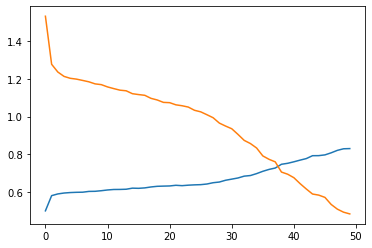

In [14]:
history = model_wav.fit(X_train_wav, Y_train_wav, batch_size=512, epochs=50, verbose=1, validation_data=(X_test_wav, Y_test_wav))
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
model_wav.save('/content/gdrive/MyDrive/Human_understand/KEMDy19/best_model_wav.h5')

In [15]:
model_wav.save('/content/gdrive/MyDrive/Human_understand/KEMDy19/best_model_wav.h5')

In [16]:
loaded_wav_model = load_model('/content/gdrive/MyDrive/Human_understand/KEMDy19/best_model_wav.h5')

In [17]:
predict_wav_accuracy=loaded_wav_model.evaluate(X_test_wav, Y_test_wav, batch_size=32)
print(predict_wav_accuracy[1])

82/82 [==============================] - 1s 8ms/step - loss: 1.9196 - accuracy: 0.5187
0.5186880230903625


In [18]:
predict_wav = loaded_wav_model.predict(X_test_wav)
print(predict_wav)

[[2.4725350e-02 2.9107934e-01 3.3042330e-01 ... 2.7230901e-01
  5.0487578e-02 1.3788635e-02]
 [2.0553608e-01 1.5111438e-03 9.9538662e-02 ... 2.0556729e-01
  4.1476759e-01 5.1895689e-02]
 [5.3278480e-02 1.2998043e-04 5.1037408e-03 ... 8.2436973e-01
  4.1209520e-03 2.1743789e-02]
 ...
 [1.5795192e-01 5.1806233e-04 1.0243000e-02 ... 7.4127978e-01
  4.9494293e-02 1.4452747e-02]
 [1.8239609e-13 1.0000000e+00 1.4320372e-12 ... 3.1535265e-15
  1.8762648e-13 7.8951890e-15]
 [2.8488696e-01 1.5481237e-04 1.1670532e-03 ... 5.7911319e-01
  1.8197650e-02 5.0437832e-03]]
